In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
index_to_save = 10

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "E",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../../../data/processed/209/e.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [9]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [10]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.572 (0.020)
MAE: -1.223 (0.018)
MAPE: -0.028 (0.000)
R2: 0.731 (0.010)


******
[TEST]
******
RMSE: -1.727 (0.131)
MAE: -1.315 (0.087)
MAPE: -0.030 (0.002)
R2: 0.670 (0.048)




<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [11]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.180 (0.206)
MAE: -0.897 (0.165)
MAPE: -0.021 (0.004)
R2: 0.757 (0.110)


******
[TEST]
******
RMSE: -1.614 (0.201)
MAE: -1.342 (0.189)
MAPE: -0.031 (0.005)
R2: -0.197 (0.983)




<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [12]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.390 (0.177)
MAE: -1.068 (0.154)
MAPE: -0.024 (0.004)
R2: 0.721 (0.109)


******
[TEST]
******
RMSE: -2.549 (0.579)
MAE: -1.979 (0.429)
MAPE: -0.046 (0.012)
R2: -0.010 (0.626)




<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 987
    2. Test: 247
<b>Total:</b> 1 model<br>

In [13]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

******
[TRAIN]
******
RMSE: 1.488 (0.000)
MAE: 1.166 (0.000)
MAPE: 0.026 (0.000)
R2: 0.791 (0.000)


******
[TEST]
******
RMSE: 2.283 (0.000)
MAE: 1.832 (0.000)
MAPE: 0.042 (0.000)
R2: -0.499 (0.000)




<IPython.core.display.Javascript object>

In [14]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features          Model            Cross Validation  \
                                                                              
0  Chemical + Properties CS Less  Random Forest  Blocking Time Series Split   
1  Chemical + Properties CS Less  Random Forest           Out of time Split   
2  Chemical + Properties CS Less  Random Forest              Repeated KFold   
3  Chemical + Properties CS Less  Random Forest           Time Series Split   

  RMSE Test            MAE Test           MAPE Test             R2 Test  \
       mean       std      mean       std      mean       std      mean   
0  1.614354  0.201429  1.341547  0.188927  0.030707  0.005481 -0.196670   
1  2.282680  0.000000  1.832289  0.000000  0.041913  0.000000 -0.498542   
2  1.727395  0.131202  1.315003  0.087269  0.030080  0.002093  0.670092   
3  2.549073  0.579368  1.979348  0.428718  0.046480  0.011614 -0.009582   

             
        std  
0  0.983466  
1  0.000000  
2  0.048134  
3  0.625666

<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [15]:
path = "../../../../../../reports/results/local_models/209/e/full/"
filename = f"random_forest_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [16]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../../reports/results/local_models/209/e/grouped/"
filename = f"random_forest_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [17]:
model = pipeline.get_params()["steps"][1][1]
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 47,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

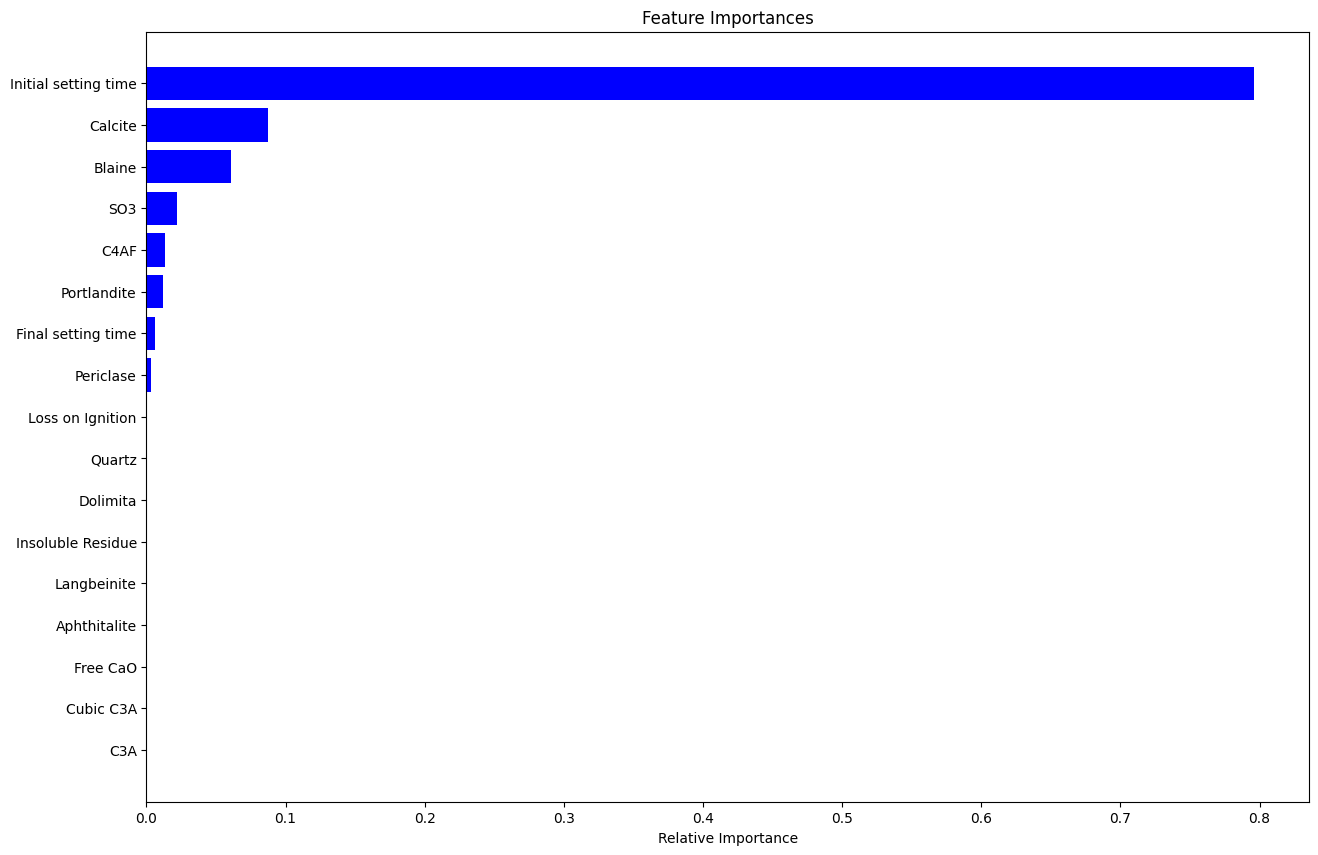

<IPython.core.display.Javascript object>

In [18]:
features = x.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show(ax)

<Axes: >

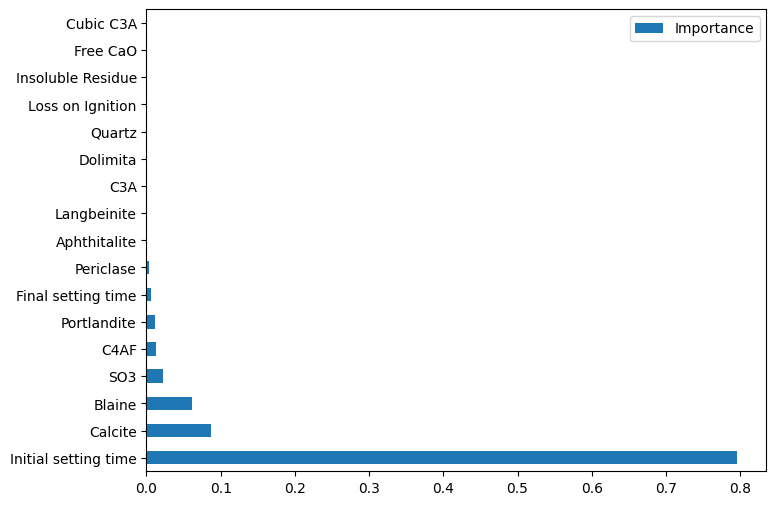

<IPython.core.display.Javascript object>

In [19]:
feat_importances = pd.DataFrame(
    model.feature_importances_, index=x.columns, columns=["Importance"]
)
feat_importances.sort_values(by="Importance", ascending=False, inplace=True)
feat_importances.plot(kind="barh", figsize=(8, 6))

In [20]:
PARAMS

{'criterion': 'squared_error',
 'n_estimators': 5,
 'max_depth': 3,
 'random_state': 47}

<IPython.core.display.Javascript object>